# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import time
import pprint
import numpy as np
import pandas as pd
import xgboost as xgb
from model.model_building import load_data, tune_hyperparam, eval_xgb_model, plot_eval

# Set up constants

In [3]:
PROCESSED_PATH = "../data/processed/IMT_Classification_Dataset_Processed_v4.xlsx"
TRAIN_RANDOM_SEED = 31415926
SCORING_METRICS = ["precision_weighted", "recall_weighted", "roc_auc", "f1_weighted"]
EVAL_RANDOM_SEEDS = np.arange(0, 10)
NUM_FOLDS = 5

# Read in the processed data

In [4]:
df = pd.read_excel(PROCESSED_PATH)
df

,Compound,Label,struct_file_path,range MendeleevNumber,avg_dev MendeleevNumber,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,range MeltingT,mean MeltingT,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,SrRuO3,0,../data/Structures/Metals/SrRuO3_75561.cif,79,26.400000,85.07060,47.337640,37.605888,2552.20,764.280000,...,3.579973,2.760023,2.947568,-44.758483,23.738172,45.000000,59.00000,10.330721,8.527722,12.089967
1,OsO2,0,../data/Structures/Metals/OsO2_15070.cif,30,13.333333,174.23060,74.076267,77.435822,3251.20,1138.533333,...,2.805520,2.442651,2.684563,-44.387080,25.269881,41.000000,55.00000,9.953087,13.687053,10.747095
2,SrLaCuO4,0,../data/Structures/Metals/LaSrCuO4_10252.cif,79,29.346939,122.90607,50.581296,39.522167,1302.97,545.710000,...,3.421841,2.662257,2.966018,-36.448400,23.905465,36.841000,57.38000,18.524833,8.820620,13.436088
3,SrCrO3,0,../data/Structures/Metals/SrCrO3_245834.cif,79,28.080000,71.62060,37.522860,25.828152,2125.20,678.880000,...,2.701006,2.701006,2.701006,-46.659812,24.337085,49.160000,69.46000,16.530261,6.586603,11.146843
4,CrO2,0,../data/Structures/Metals/CrO2_202836.cif,38,16.888889,35.99670,27.998300,15.998533,2125.20,763.200000,...,2.688819,2.471404,2.616347,-46.102564,26.561430,49.160000,69.46000,16.126339,8.219417,9.504907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,YbFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YbCu3Fe...,48,14.700000,157.05460,38.953240,27.544608,1756.20,653.345500,...,2.924013,2.552849,2.744642,-33.639068,24.360992,36.841000,57.38000,16.597335,7.361181,9.750947
224,NiSeS,2,../data/Structures/MIT_materials/HighT/NiS(2-x...,28,12.222222,46.89500,56.572800,16.338533,1339.64,870.120000,...,3.287898,2.376963,3.060164,-18.496007,9.778249,18.168838,35.18700,13.516153,8.891048,16.385810
225,Ti2O3,2,../data/Structures/MIT_materials/HighT/Ti2O3_H...,44,21.120000,31.86760,28.746440,15.296448,1886.20,809.280000,...,2.900002,2.771288,2.844355,-33.753924,24.648770,27.491710,43.26717,11.068473,16.169806,10.490597
226,Ca1.2La2.8Mn4O12,2,../data/Structures/MIT_materials/HighT/La0.7Ca...,80,26.592000,122.90607,42.438695,32.010437,1464.20,570.600000,...,3.516261,2.747250,2.906344,-39.888114,22.934073,38.930600,57.57000,14.915598,8.843086,11.576092


# Tune the hyperparameters with 5-fold cv

The default parameter grid is as follows:

    n_estimators: [10, 20, 30, 40, 80, 100, 150, 200],
    max_depth: [2, 3, 5],
    learning_rate: np.logspace(-3, 2, num=6),
    scale_pos_weight: [np.sum(y_labels == 0) / np.sum(y_labels == 1)],
    base_score: [0.3, 0.5, 0.7]
    
The scoring metric for the gridsearch cv is `f1_weighted`. You can also change the number of cv fold by specifying `num_folds` and the default parameter grid by specifying `xgb_param_grid`.

In [5]:
best_params = {choice: tune_hyperparam(df, choice, TRAIN_RANDOM_SEED)
               for choice in ["Metal", "Insulator", "MIT"]}
# pause the execution for 1 second to ensure proper printout format
time.sleep(1)
print("\nBest parameters:")
pprint.pprint(best_params)


Tuning for Metal vs. non-Metal binary classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2145 out of 2160 | elapsed:   29.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   29.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for Insulator vs. non-Insulator binary classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   32.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Tuning for MIT vs. non-MIT binary classifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   31.8s finished



Best parameters:
{'Insulator': {'base_score': 0.3,
               'learning_rate': 0.1,
               'max_depth': 3,
               'n_estimators': 200,
               'scale_pos_weight': 1.6823529411764706},
 'MIT': {'base_score': 0.7,
         'learning_rate': 0.1,
         'max_depth': 3,
         'n_estimators': 150,
         'scale_pos_weight': 1.0727272727272728},
 'Metal': {'base_score': 0.5,
           'learning_rate': 1.0,
           'max_depth': 2,
           'n_estimators': 80,
           'scale_pos_weight': 5.909090909090909}}


# Evaluate the tuned model with 5-fold stratified cv under 10 seeds (0-9)

Since the stratified cross validation splits are dependent on the random seeds, we use a series of 10 seeds (i.e. 0-9) to evaluate the tuned models' performance. That is to say for each seed and each metric, a stratified 5-fold cv is carried out, from which we take a median/mean value. Then for 10 seeds, there are 10 values. Finally, we will take a median/mean out of the 10 values. Essentially, the numbers printed below are either a median of medians or an average of averages.

The default printout is a median value with the interquartile range (IQR).

In [6]:
for choice in ["Metal", "Insulator", "MIT"]:
    eval_xgb_model(EVAL_RANDOM_SEEDS, SCORING_METRICS, choice, df_input=df, params=best_params, method="robust",
                   num_folds=NUM_FOLDS)


Evaluating the Metal vs. non-Metal binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.87 w/ IQR: 0.02
Median recall_weighted: 0.88 w/ IQR: 0.02
Median roc_auc: 0.85 w/ IQR: 0.02
Median f1_weighted: 0.87 w/ IQR: 0.03

Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.88 w/ IQR: 0.03
Median recall_weighted: 0.87 w/ IQR: 0.02
Median roc_auc: 0.93 w/ IQR: 0.02
Median f1_weighted: 0.87 w/ IQR: 0.02

Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Median precision_weighted: 0.87 w/ IQR: 0.02
Median recall_weighted: 0.87 w/ IQR: 0.02
Median roc_auc: 0.93 w/ IQR: 0.02
Median f1_weighted: 0.87 w/ IQR: 0.02


You can also change the printout format to an average with standard deviation (std).

In [7]:
for choice in ["Metal", "Insulator", "MIT"]:
    eval_xgb_model(EVAL_RANDOM_SEEDS, SCORING_METRICS, choice, df_input=df, params=best_params, method="standard",
                   num_folds=NUM_FOLDS)


Evaluating the Metal vs. non-Metal binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.87 w/ std: 0.02
Mean recall_weighted: 0.87 w/ std: 0.02
Mean roc_auc: 0.86 w/ std: 0.02
Mean f1_weighted: 0.87 w/ std: 0.02

Evaluating the Insulator vs. non-Insulator binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.87 w/ std: 0.01
Mean recall_weighted: 0.87 w/ std: 0.01
Mean roc_auc: 0.93 w/ std: 0.01
Mean f1_weighted: 0.86 w/ std: 0.01

Evaluating the MIT vs. non-MIT binary classifier using the following seeds
[0 1 2 3 4 5 6 7 8 9]
Mean precision_weighted: 0.88 w/ std: 0.01
Mean recall_weighted: 0.88 w/ std: 0.01
Mean roc_auc: 0.94 w/ std: 0.01
Mean f1_weighted: 0.88 w/ std: 0.01


# Plot the ROC and precision recall curves

For the ROC and precision recall curves, each solid line is a median curve for a 5-fold cv under a given seed. Because there are 10 seeds, there should be 10 lines. However, some values may overlap for curves from different seeds so it may appear that there are less than 10 lines. The default setting is the same as before with 10 seeds (0-9), each with a 5-fold stratified cv.

## ROC curve

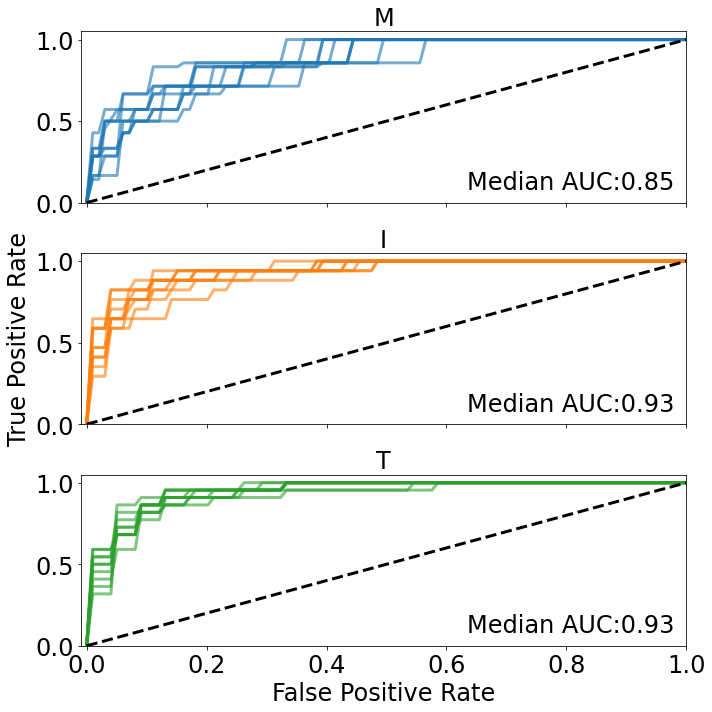

In [8]:
roc_curve = plot_eval(df, best_params, eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS)

You may also choose to plot the mean curve for each seed by specifying the `stat_func` argument as `np.mean`. The same is true for the precision-recall curve.

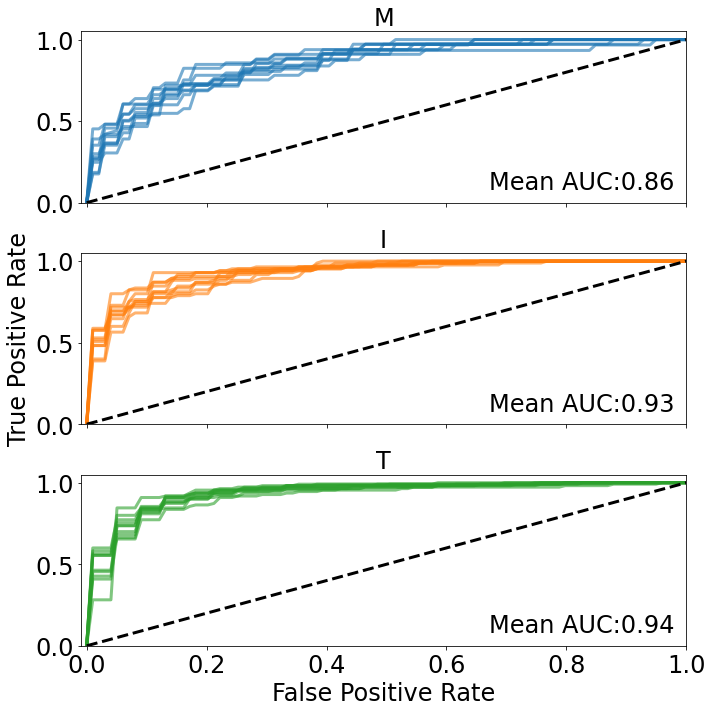

In [9]:
roc_curve_mean = plot_eval(df, best_params, eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS, stat_func=np.mean)

## Precision-recall curve

For each precision-recall curve, there is a naive precision line. This line just represents the precision value from a naive classifier that always predict the positive class. As a result, the naive precision is equal to the proportion of the positive class for each binary classification. For instance, around 14% of the observations are metals.

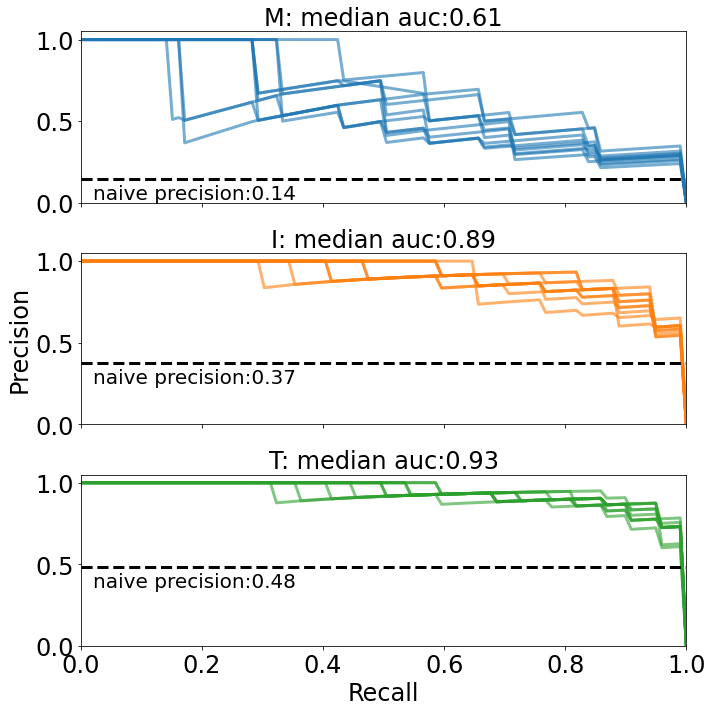

In [10]:
pr_curve = plot_eval(df, best_params, eval_seeds=EVAL_RANDOM_SEEDS, num_folds=NUM_FOLDS, eval_method="pr")

# Train on the entire dataset and save the models

In [11]:
for choice in ["Metal", "Insulator", "MIT"]:
    X, y = load_data(df, choice)
    xgb_tuned_model = xgb.XGBClassifier(**best_params[choice])
    xgb_tuned_model.fit(X, y)
    xgb_tuned_model.save_model("../model/saved_models/new_models/{}.model".format(choice.lower()))